<a href="https://colab.research.google.com/github/ayaanzhaque/APCSP-Create/blob/master/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## pytorch-uent

https://github.com/usuyama/pytorch-unet

In [42]:
!git clone https://github.com/usuyama/pytorch-unet.git

%cd pytorch-unet

fatal: destination path 'pytorch-unet' already exists and is not an empty directory.
/content/pytorch-unet


In [43]:
!ls

helper.py  __pycache__			pytorch_unet.py
images	   pytorch_fcn.ipynb		pytorch_unet_resnet18_colab.ipynb
LICENSE    pytorch_resnet18_unet.ipynb	README.md
loss.py    pytorch_unet.ipynb		simulation.py


## Colab Setup


In [44]:
import torch
import pdb

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla K80


In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [46]:
from scipy.io import loadmat
datamat = loadmat('/content/drive/My Drive/Research/jsrt.mat')

In [47]:
datamat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test'])

In [48]:
x_train = datamat["x_train"]
y_train = datamat["y_train"]
x_val = datamat["x_val"]
y_val = datamat["y_val"]
x_test = datamat["x_test"]
y_test = datamat["y_test"]

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

x_train = np.array(x_train).reshape(len(x_train),256, 256)
y_train = y_train[:,:,:,0] + y_train[:,:,:,1]
y_train = np.array(y_train).reshape(len(y_train),1, 256, 256)

x_val = np.array(x_val).reshape(len(x_val),256, 256)
y_val = y_val[:,:,:,0] + y_val[:,:,:,1]
y_val = np.array(y_val).reshape(len(y_val),1, 256, 256)

x_test = np.array(x_test).reshape(len(x_test),256, 256)
y_test = y_test[:,:,:,0] + y_test[:,:,:,1]
y_test = np.array(y_test).reshape(len(y_test),1, 256, 256)

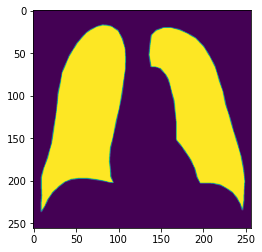

In [50]:
plt.imshow(np.squeeze(y_train[100]))
# plt.imshow(y_train[100])

In [51]:
y_train.shape

(111, 1, 256, 256)

## Show Data

In [52]:
# helper.plot_side_by_side([x_train, y_train])

## Prepare Dataset and DataLoader

In [53]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class Dataset(Dataset):
  def __init__(self, x, y, transform=None):
    self.input_images = x
    self.target_masks = y
    self.transform = transform

  def __len__(self):
    return len(self.input_images)

  def __getitem__(self, idx):
    image = self.input_images[idx]
    mask = self.target_masks[idx]
    if self.transform:
      image = self.transform(image)

    return [image, mask]

# use the same transformations for train/val in this example
trans = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5), (0.5)) # imagenet
])

train_set = Dataset(x_train, y_train, transform = trans)
val_set = Dataset(x_val, y_val, transform = trans)

image_datasets = {
  'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
  'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2),
  'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
}

torch.Size([25, 1, 256, 256]) torch.Size([25, 1, 256, 256])
<class 'torch.Tensor'>


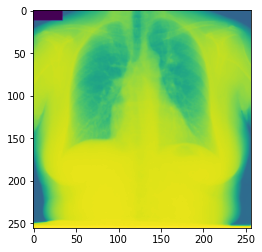

In [54]:
import torchvision.utils

def reverse_transform(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)

  return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)

print(type(inputs))

plt.imshow(np.squeeze(inputs[0]))

# Define a UNet module

In [55]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

## Instantiate the UNet model

In [56]:
import torch
import torch.nn as nn
# import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(1)
model = model.to(device)

In [57]:
model

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [58]:
from torchsummary import summary
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

# Define the main training loop

In [59]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss
import copy

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    return "{}: {}".format(phase, ", ".join(outputs))

def train_model(model, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        text = ('Epoch {}/{}'.format(epoch, num_epochs - 1) + "\n")
        file.write(text)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device=device, dtype=torch.float)
                labels = labels.to(device=device, dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print(print_metrics(metrics, epoch_samples, phase))
            text = (print_metrics(metrics, epoch_samples, phase) + "\n")
            file.write(text)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Training

In [60]:
%cd /content
file = open("UNetPerformance.txt", "w")

/content


In [63]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

num_class = 1
model = UNet(1).to(device)

# freeze backbone layers
# for l in model.base_layers:
#   for param in l.parameters():
#     param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
LR 0.0001


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.707617, dice: 0.618947, loss: 0.663282
val: bce: 0.703709, dice: 0.627789, loss: 0.665749
saving best model
0m 14s
Epoch 1/49
----------
LR 0.0001
train: bce: 0.700905, dice: 0.619491, loss: 0.660198
val: bce: 0.695982, dice: 0.628350, loss: 0.662166
saving best model
0m 14s
Epoch 2/49
----------
LR 0.0001
train: bce: 0.689338, dice: 0.620655, loss: 0.654997
val: bce: 0.659652, dice: 0.632975, loss: 0.646314
saving best model
0m 14s
Epoch 3/49
----------
LR 0.0001
train: bce: 0.613642, dice: 0.645450, loss: 0.629546
val: bce: 0.553355, dice: 0.653776, loss: 0.603565
saving best model
0m 14s
Epoch 4/49
----------
LR 0.0001
train: bce: 0.559415, dice: 0.636066, loss: 0.597741
val: bce: 0.482364, dice: 0.621171, loss: 0.551767
saving best model
0m 14s
Epoch 5/49
----------
LR 0.0001
train: bce: 0.498938, dice: 0.602955, loss: 0.550946
val: bce: 0.414541, dice: 0.548190, loss: 0.481365
saving best model
0m 14s
Epoch 6/49
----------
LR 0.0001
train: bce: 0.454393, dice: 0.5487

In [64]:
file.close()
from google.colab import files
files.download("/content/UNetPerformance.txt") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Predict new images using the trained model

inputs.shape torch.Size([3, 1, 256, 256])
labels.shape torch.Size([3, 1, 256, 256])
pred.shape (3, 1, 256, 256)


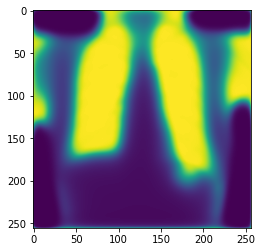

In [65]:
import math

model.eval()   # Set model to the evaluation mode

# Create a new simulation dataset for testing
test_dataset = Dataset(x_test, y_test, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device=device, dtype=torch.float)
labels = labels.to(device=device, dtype=torch.float)
print('inputs.shape', inputs.shape)
print('labels.shape', labels.shape)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print('pred.shape', pred.shape)


plt.imshow(np.squeeze(pred[2]))

In [ ]:
plt.imshow(np.squeeze(y_test[2]))

## Left: Input image, Middle: Correct mask (Ground-truth), Rigth: Predicted mask

In [ ]:
helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])